In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
from IPython.display import display, clear_output
from scipy import signal
from scipy import fftpack
from numpy.fft import fft, fftfreq
import os
import pandas as pd

# import custom module
import SIRS


from itertools import *
from operator import *

# Probability of extinction and extinction time

In [69]:
def extinction(I, ext_win):
    
    extinted = False
    time_extinction = -1
    
    possible_ext_time = np.argwhere(I==0.)
    
    for key, group in groupby(enumerate(possible_ext_time), lambda x: x[0] - x[1]): 
        group = list(map(itemgetter(1), group)) 
        if len(group) >= ext_win:
            extinted = True
            time_extinction = group[0]
            #return extinted, time_extinction
    return extinted, time_extinction

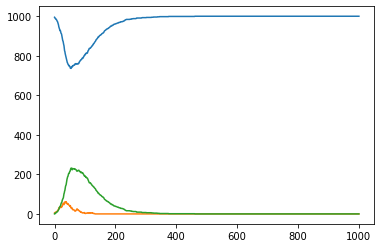

True
[133]


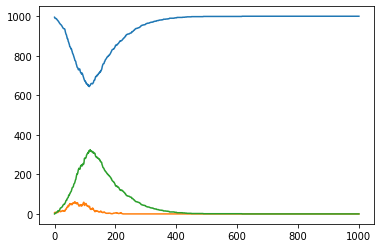

True
[225]


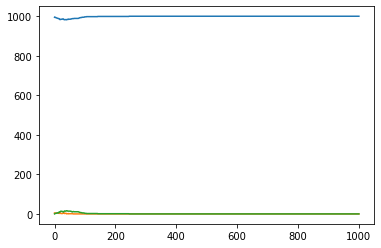

True
[61]


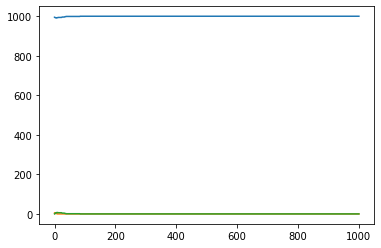

True
[9]


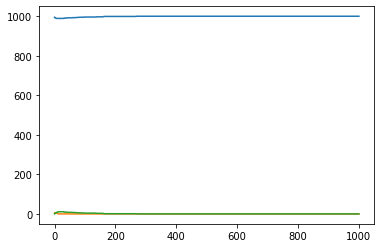

True
[12]


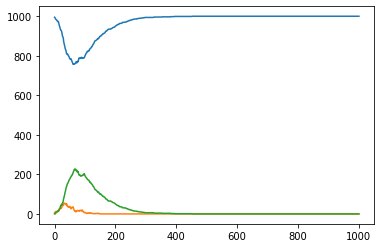

True
[150]


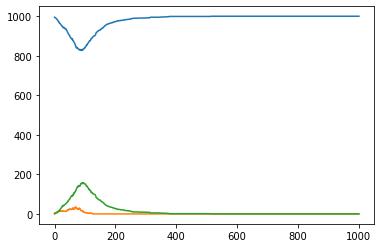

True
[129]


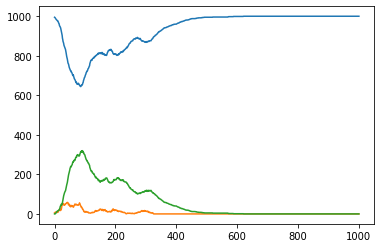

True
[326]


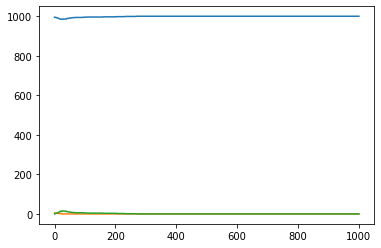

True
[26]


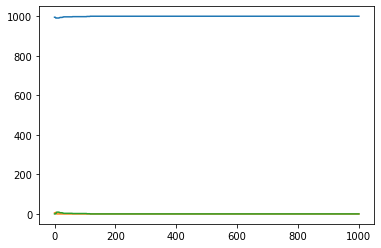

True
[7]


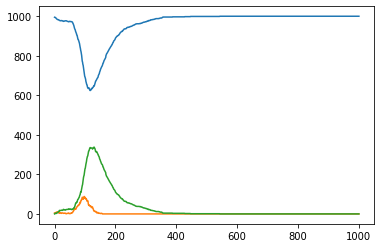

True
[157]


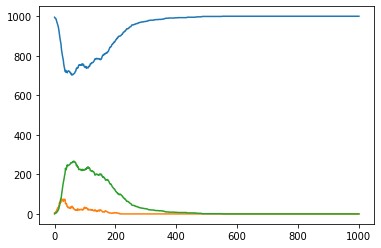

True
[216]


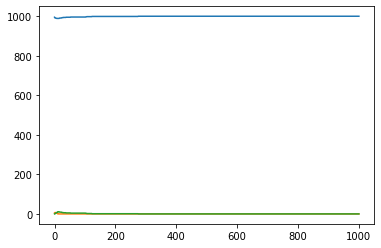

True
[11]


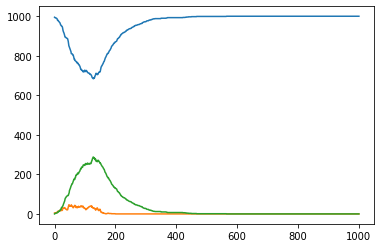

True
[200]


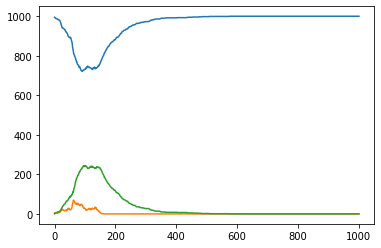

True
[163]


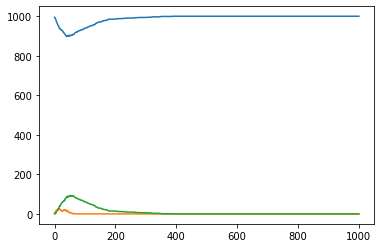

True
[71]


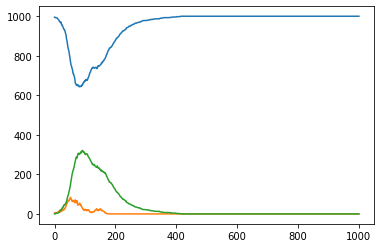

True
[180]


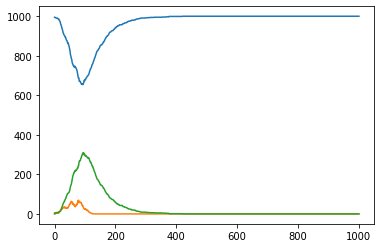

True
[126]


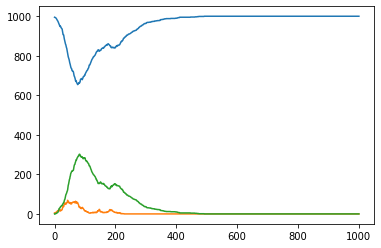

True
[229]


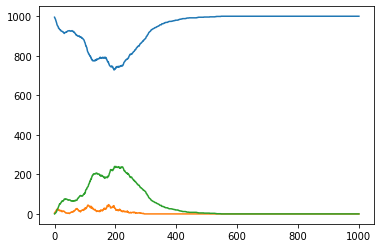

True
[295]


In [74]:
ext=[] #will give me probability of extincion
t_ext=[]

for i in range(0,20,1):
    filename = "0.0625_0.15_0.0165/SIR_er_"+str(i)+".txt"
    SIR = np.loadtxt(filename)
    wind=40
    '''
    plt.plot(np.linspace(0,len(SIR),len(SIR)),SIR[:,0])
    plt.plot(np.linspace(0,len(SIR),len(SIR)),SIR[:,1])
    plt.plot(np.linspace(0,len(SIR),len(SIR)),SIR[:,2])
    plt.show()
    '''
    e, t = extinction(SIR[:,1], wind)
    ext.append(e)
    t_ext.append(t)
